In [ ]:
#import libraries
import numpy as np
from ase.io import read, write
from ase import Atoms
import torch
import yaml
import json
import matplotlib.pyplot as plt
import pandas as pd
import os
os.makedirs('img_res', exist_ok=True) #creates a folder to store the loss graphs
os.makedirs('test_res', exist_ok=True) #creates a folder to store the files of the testing of the model

In [2]:
#I found a warning regarding the key names for energy and forces, the label changes from 'energy' to 'REF_energy'
input_file = "251017_training_data.xyz"
output_file = "251017_training_data_fixed.xyz"

with open(input_file, "r") as f:
    lines = f.readlines()

new_lines = []
for line in lines:
    # Fix energy key in header lines
    if "energy=" in line:
        line = line.replace("energy=", "REF_energy=")
    # Fix forces key in Properties line
    if "Properties=" in line and "forces:R:3" in line:
        line = line.replace("forces:R:3", "REF_forces:R:3")
    new_lines.append(line)

# Write the fixed file
with open(output_file, "w") as f:
    f.writelines(new_lines)

In [3]:
#importing the full data (this is in case I have like the whole data in one file)
db = read('251017_training_data_fixed.xyz', ':')

In [17]:
#splitting the data into the training and test sets
write('train_01.xyz', db[:520])
write('test_01.xyz', db[520:])

In [66]:
#setting the model name based on model number and epochs
''' model_num:
    1 -> this indicates the model using 250 training data
    2 -> this indicates the model using 520 training data which is 80% of the data set '''
model_num = 2
''' num_epochs:
    sets the number of epochs used for running the trainig'''
num_epoch = 30
''' batch_size:
    sets the batch size for training'''
batch_size = 32
''' model_name:
    generates the name of the model based on the number of epochs and the model number using the 'model_num' variable '''
model_name = f'model_0{model_num}_{num_epoch}epochs_{batch_size}batch'
model_name

'model_02_30epochs_32batch'

In [67]:
#this writes the yml file
config = {
    "model": "MACE",
    "num_channels": 32,
    "max_L": 0,
    "r_max": 4.0,
    "name": model_name,
    "train_file": f"train_01.xyz",
    "valid_fraction": 0.01,
    "test_file": f"test_01.xyz",
    "energy_key": "REF_energy",
    "forces_key": "REF_forces",
    "batch_size": batch_size,
    "max_num_epochs": num_epoch,
    "device": "cuda",
    "seed": 123
}
with open("config_new_model.yml", "w") as f:
    yaml.dump(config, f, sort_keys=False)

In [68]:
#Perform training
import warnings
warnings.filterwarnings('ignore')
from mace.cli.run_train import main as mace_run_train_main
import sys
import logging

#defining the training function
def train_mace(config_file_path):
    logging.getLogger().handlers.clear()
    sys.argv = ['program', '--config', config_file_path]
    mace_run_train_main()

#calling the function
train_mace('config_new_model.yml') # use the name of the config file that was created

2025-10-22 18:13:09.182 INFO: ===========VERIFYING SETTINGS===========
2025-10-22 18:13:09.182 INFO: MACE version: 0.3.14
2025-10-22 18:13:09.182 INFO: CUDA version: 12.6, CUDA device: 0
2025-10-22 18:13:09.215 INFO: ===========LOADING INPUT DATA===========
2025-10-22 18:13:09.215 INFO: Using heads: ['Default']
2025-10-22 18:13:09.215 INFO: Using the key specifications to parse data:
2025-10-22 18:13:09.215 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head', 'elec_temp': 'elec_temp', 'total_charge': 'total_charge', 'polarizability': 'polarizability', 'total_spin': 'total_spin'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-10-22 18:13:09.215 INFO: =============    Processing head Default     ===========
2025-10-22 18:13:09.360 INFO: Using isolated atom energies from training file
2025-10-22 18:13:09.378 INFO: Training set 1/1 [energy: 517, stress: 0, virials: 0, 

In [69]:
#reading the information on the results file
results = f'results/{model_name}_run-123_train.txt' #reading the file where the training results is stored
data = [] #where the data from the 'results' file will be stored
with open(results, 'r') as f:
    for line in f:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError:
            continue

In [70]:
#saving the data in a dataframe to be able to work with it in an easier way
df = pd.DataFrame(data)
#separating the training and validation results
train_df = df[df['mode']=='opt'].copy()
val_df = df[df['mode']=='eval'].copy().dropna()
train_df = train_df.groupby('epoch', as_index=False)['loss'].last()
train_df['epoch'] += 1
val_df['epoch'] += 1

In [71]:
#df[df['mode']=='opt']
#val_df

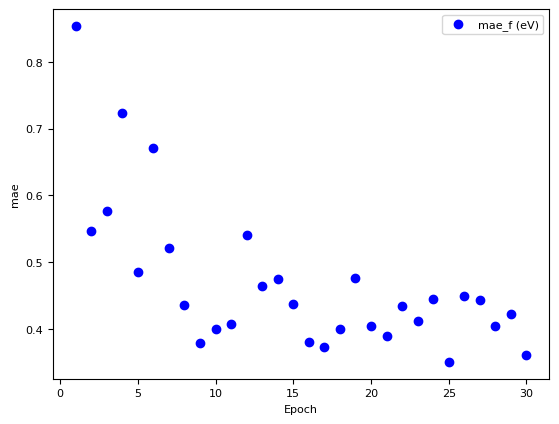

In [72]:
#I found out that the values of mae_e and mae_f are also important, so I will add them here
plt.scatter(val_df['epoch'], val_df['mae_f'], label='mae_f (eV)', color='blue')
plt.xlabel('Epoch')
plt.ylabel('mae')
plt.legend()

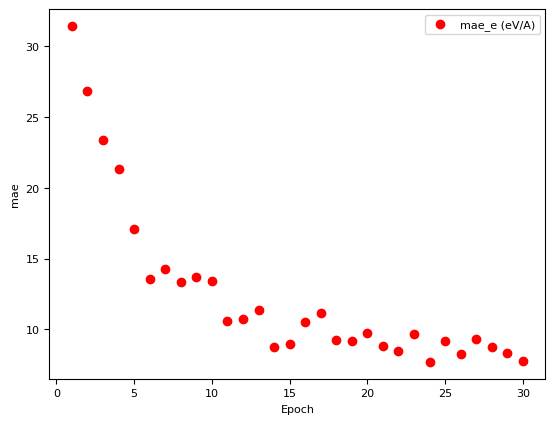

In [73]:
#I found out that the values of mae_e and mae_f are also important, so I will add them here
plt.scatter(val_df['epoch'], val_df['mae_e'], label='mae_e (eV/A)', color='red')
plt.xlabel('Epoch')
plt.ylabel('mae')
plt.legend()

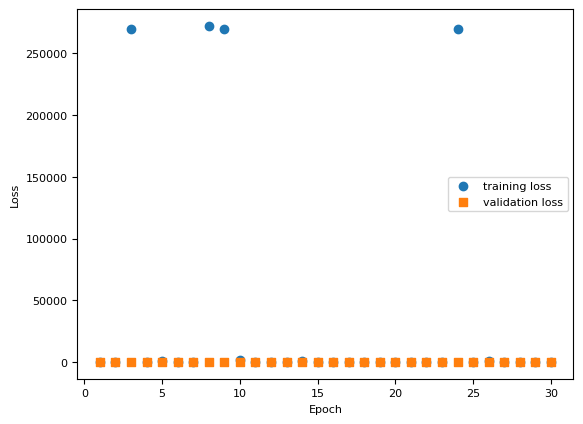

In [74]:
#plotting the 
#plt.figure()
plt.scatter(train_df['epoch'],train_df['loss'], label='training loss', marker='o')
plt.scatter(val_df['epoch'],val_df['loss'], label='validation loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

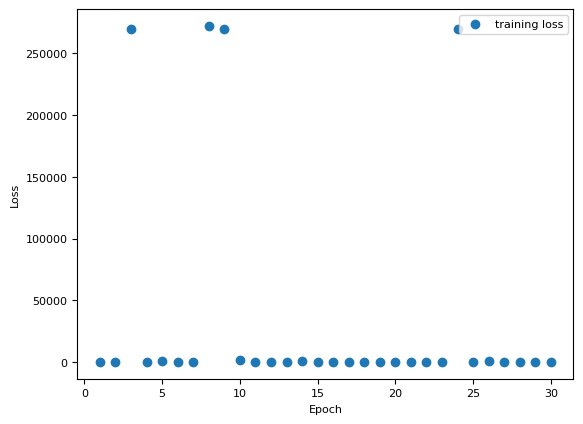

In [75]:
#plt.figure()
plt.scatter(train_df['epoch'],train_df['loss'], label='training loss', marker='o')
#plt.scatter(val_df['epoch'],val_df['loss'], label='validation loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#saving the plots
last_epoch = int(train_df['epoch'].max())
filename = f'img_res/{model_name}_train_loss.pdf'
plt.savefig(filename)

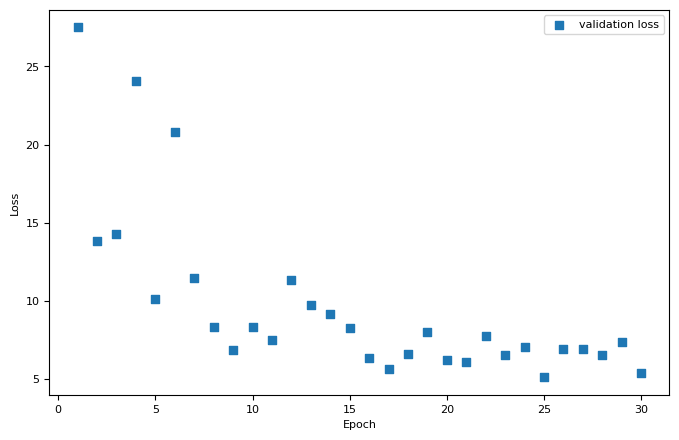

In [76]:
plt.figure(figsize=(8,5))
#plt.scatter(train_df['epoch'],train_df['loss'], label='training loss', marker='o')
plt.scatter(val_df['epoch'],val_df['loss'], label='validation loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#saving the plots
last_epoch = int(train_df['epoch'].max())
filename = f'img_res/{model_name}_val_loss.pdf'
plt.savefig(filename)

In [ ]:
#the model can be evaluated using this
from mace.cli.eval_configs import main as mace_eval_configs_main

def eval_mace(model, configs, output, device):
    sys.argv['program', '--configs', configs, '--model', model, '--output', output]
    mace_eval_configs_main()

In [ ]:
#evaluating the set on both the training and test data sets
eval_mace(model=f'{model_name}.model',
          configs='train_01.xyz',
          output=f'test_res/{model_name}_train.xyz')

eval_mace(model=f'{model_name}.model',
          configs='test_01.xyz',
          output=f'test_res/{model_name}_test.xyz')

In [1]:
'''#this is commented for now because we have set the data on which the energy and forces will be calculated
#once the training is done, then a calculation can be performed using ase
from ase.io import read
from mace.calculators import MACECalculator

#loading the model
calculator = MACECalculator(model_paths=f'{model_name}.model', device='cuda')
#read the configurations from where we want to calculate
### I set here the training data, but we could also calculate it on different data to see how it actually performs on new data
configs = read('test_01.xyz', ':')

#set a list to store the information
results = []
# read the results
for i, atoms in enumerate(configs):
    atoms.set_calculator(calculator)
    energy = atoms.get_potential_energy()
    forces = atoms.get_forces()
    #max_force = abs(forces).max()  # max absolute force
    #mean_force = abs(forces).mean()  # mean absolute force
    # Add to list
    results.append({
        "config_id": i,
        "energy (eV)": energy,
    #    "max_force (eV/Å)": max_force,
    #    "mean_force (eV/Å)": mean_force,
        "num_atoms": len(atoms)
    })
# Create dataframe
df = pd.DataFrame(results)
df.to_excel(f'{model_name}.xlsx', index=False) #this is to save the results in an exel file'''

'#this is commented for now because we have set the data on which the energy and forces will be calculated\n#once the training is done, then a calculation can be performed using ase\nfrom ase.io import read\nfrom mace.calculators import MACECalculator\n\n#loading the model\ncalculator = MACECalculator(model_paths=f\'{model_name}.model\', device=\'cuda\')\n#read the configurations from where we want to calculate\n### I set here the training data, but we could also calculate it on different data to see how it actually performs on new data\nconfigs = read(\'test_01.xyz\', \':\')\n\n#set a list to store the information\nresults = []\n# read the results\nfor i, atoms in enumerate(configs):\n    atoms.set_calculator(calculator)\n    energy = atoms.get_potential_energy()\n    forces = atoms.get_forces()\n    #max_force = abs(forces).max()  # max absolute force\n    #mean_force = abs(forces).mean()  # mean absolute force\n    # Add to list\n    results.append({\n        "config_id": i,\n      